In [1]:
import sys
sys.path.append('venv/lib/python3.12/site-packages/')

In [2]:
import networkx as nx
import matplotlib.pyplot as plt
import itertools

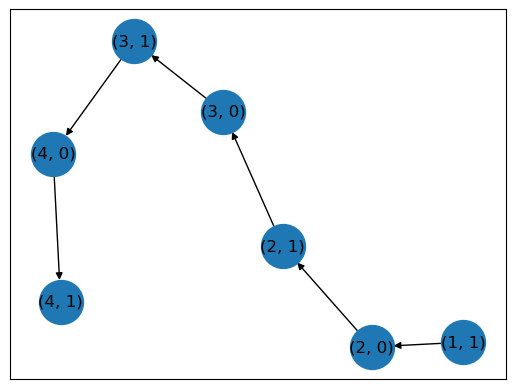

In [3]:
# Assumption is that we're dealing only with flowbits that have read + write operations in them at this point

# Step 3 of the solution
# Create a directed graph
G = nx.DiGraph()

sigs = []

# Dataset with cyclic dependencies present
# sigs = [
#     # Node types available: Signature (0), Flowbit (1)
#     # Flowbit cmds available: 0 (READ), 1 (WRITE)
#     # Format is: sig number, node type, [flowbit number, node type, cmd] * number of flowbits in that signature
#     # sid:2; flowbits:isset,fb1; flowbits:set,fb2;
#     [(2, 0), (1, 1, 0), (2, 1, 1)],
#     # sid:3; flowbits:isset,fb4; flowbits:set,fb3;
#     [(3, 0), (4, 1, 0), (3, 1, 1)],
#     # sid:4; flowbits:isset,fb3; flowbits:set,fb4;
#     [(4, 0), (3, 1, 0), (4, 1, 1)],
# ]

# Simple Dataset without any complex dependencies present
sigs = [
    # Node types available: Signature (0), Flowbit (1)
    # Flowbit cmds available: 0 (READ), 1 (WRITE)
    # Format is: sig number, node type, [flowbit number, node type, cmd] * number of flowbits in that signature
    # sid:2; flowbits:isset,fb1; flowbits:set,fb2;
    [(2, 0), (1, 1, 0), (2, 1, 1)],
    # sid:3; flowbits:isset,fb2; flowbits:set,fb3;
    [(3, 0), (2, 1, 0), (3, 1, 1)],
    # sid:4; flowbits:isset,fb3; flowbits:set,fb4;
    [(4, 0), (3, 1, 0), (4, 1, 1)],
]

# Dataset with complex dependencies present
# sigs = [
#     # Node types available: Signature (0), Flowbit (1)
#     # Flowbit cmds available: 0 (READ), 1 (WRITE)
#     # Format is: sig number, node type, [flowbit number, node type, cmd] * number of flowbits in that signature
#     # sid:2; flowbits:isset,fb1; flowbits:set,fb2;
#     [(2, 0), (1, 1, 0), (2, 1, 1)],
#     # sid:3; flowbits:isset,fb3; flowbits:set,fb1;
#     [(3, 0), (3, 1, 0), (1, 1, 1)],
#     # sid:4; flowbits:set,fb4; flowbits:isset,fb2;
#     [(4, 0), (4, 1, 1), (2, 1, 0)],
# ]

# Dataset without complex dependencies but disjointed graphs
# sigs = [
#     # Node types available: Signature (0), Flowbit (1)
#     # Flowbit cmds available: 0 (READ), 1 (WRITE)
#     # Format is: sig number, node type, [flowbit number, node type, cmd] * number of flowbits in that signature
#     # sid:2; flowbits:isset,fb1; flowbits:set,fb2;
#     [(2, 0), (1, 1, 0), (2, 1, 1)],
#     # sid:3; flowbits:isset,fb2; flowbits:set,fb3;
#     [(3, 0), (2, 1, 0), (3, 1, 1)],
#     # sid:4; flowbits:isset,fb5; flowbits:set,fb4;
#     [(4, 0), (5, 1, 0), (4, 1, 1)],
#     # sid:5; flowbits:isset,fb4; flowbits:set,fb7;
#     [(5, 0), (4, 1, 0), (7, 1, 1)],
# ]

for sig in sigs:
    s = ()
    for nd in sig:
        if nd[1] == 0: # it's a signature type node
            assert len(nd) == 2
            s = nd
            G.add_node(nd)
        elif nd[1] == 1: # it's a flowbit type node
            assert len(nd) == 3
            node = (nd[0], nd[1])
            G.add_node(node)
            if nd[2] == 1: # it's a write command
                G.add_edge(s, node) # edge goes from signature to the flowbit object
            else:
                assert nd[2] == 0 # shouldn't have any other states than READ or WRITE
                G.add_edge(node, s) # edge goes from flowbit to signature indicating flowbit is dependent on this signature
        else:
             assert "Incorrect type provided" 
                
nx.draw_networkx(G, with_labels = True, node_size = 1000)
plt.show()

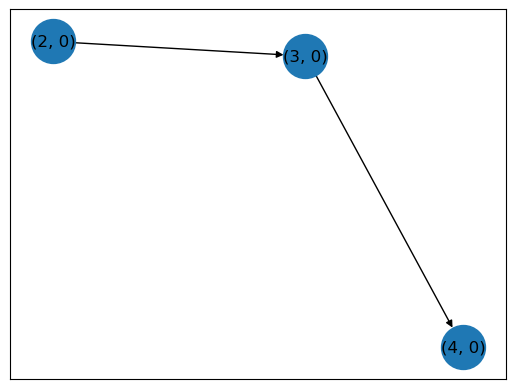

In [4]:
# Step 4 of the solution
# Normalize the graph to remove the flowbit nodes

nodes = list(G.nodes())

for node in nodes:
    if node[1] == 1: # it's a flowbit!
#        print("NODE: " + str(node))
        in_edges = list(G.in_edges(node))
        out_edges = list(G.out_edges(node))
        if len(in_edges) > 0:
            in_edges = [n for n in in_edges[0] if n != node]
#            print("IN: " + str(in_edges))
        if len(out_edges) > 0:
            out_edges = [n for n in out_edges[0] if n != node]
#            print("OUT: " + str(out_edges))
        map_new_edges = list(itertools.product(in_edges, out_edges)) # Create a map of in and out edges
#        print(map_new_edges)
        for edge in map_new_edges:
            G.add_edge(edge[0], edge[1]) # add an edge between the mapped edges
            G.remove_node(node) # remove the flowbit node
            
        if len(map_new_edges) == 0:
            G.remove_node(node) # if flowbit node is terminal, it serves no purpose in complex dependencies, remove it
            
nx.draw_networkx(G, with_labels = True, node_size = 1000)
plt.show()

In [5]:
# Step 5 of the solution
# Detect cycles in the graph

cycles = list(nx.simple_cycles(G)) # Get all cycles in the graph, if any

if len(cycles) > 0:
    print("CYCLE!")
    # and we exit here
    raise

In [6]:
# Step 6 of the solution
# At this point, we're sure that we have a DAG

in_nodes = [n for n, deg in G.in_degree() if deg == 0] # nodes with no inward edges; so top of the final resolved order
out_nodes = [n for n, deg in G.out_degree() if deg == 0] # nodes with no outward edges; so bottom of the final resolved order

dummy_node = (0, 99)
G.add_node(dummy_node)

for node in in_nodes:
    G.add_edge(dummy_node, node) # add a dummy edge to all disjoint graph's first nodes (nodes with no in edges)

bfs_tree = nx.bfs_tree(G, dummy_node)
bfs_nodes_list = list(bfs_tree.nodes())
#print(list(bfs_nodes_list))

fin_sorted_list = bfs_nodes_list[1:] # remove the dummy node; no longer needed

print("Correct order of the signatures should be:")
for sig in fin_sorted_list:
    print("sid: " + str(sig[0]))
    
# FIN.

Correct order of the signatures should be:
sid: 2
sid: 3
sid: 4
